## Notebook Overview

The notebook includes a simple implementation of the **Byte Pair Encoding** (BPE) algorithm and some sample visualizations. 

The implementation of the algorithm is by no means perfect. I am confident that there are a ton of ways to optimize my code. However, the notebook was created for my educational purposes only and I just wanted to get a basic idea of how this process works. This exercise actually seemed to be an interesting LeetCode like puzzle, I wouldn't be surprised if it is one of the problems on there.


#### BPE Explained
BPE is used to tokenize text and is the basis for some of the SOTA approaches to tokenization today, mainly byte-level BPE. 

The algorithm's training method can be summed up in these steps:
1. Split the training string into characters 
2. Find the most frequent adjacent pairs of characters
3. Merge the pair everywhere it appears and add the new merged pair as a new token option.
4. Repeat steps 2-3 until you've reached the target token vocab size.

In my implementation I chose to separate the string into words first and not deal with spaces as a token. I thought that this could make my token list be more focused on finding the subwords first instead of being "distracted" by seperating words using spaces.

When we want to tokenize a string:
1. Sort the tokens from longest to shortest
2. Initialize a pointer to the start of the string
3. Find the largest token that could match the string starting from the pointer
4. Add that token to our output list and move the pointer by `len(token)`
5. Repeat steps 3-4 until we tokenized the full string
6. Return the list of tokens



In [1]:
class BPE:

    def __init__(self, string):
        self.string = string
        self.tokens = self._get_vocab(string)
        self.list_of_words = self._set_list_of_words()
        self.tokenized_words_list = [self._convert_str_to_char_list(word) for word in self.list_of_words]
        self.neighbors = {}

    def _get_vocab(self, string):
        vocab = []
        for char in string:
            if char.isalpha() and char.lower() not in vocab:  
                vocab.append(char.lower())  
        return vocab

    def _set_list_of_words(self):
        return self.string.split()

    def _convert_str_to_char_list(self, string):
        char_list = []
        for char in string:
            if char.isalpha():  
                char_list.append(char.lower())  
        return char_list

    def _count_neighbors(self, tokenized_word):
        for i in range(len(tokenized_word) - 1):
            pair = (tokenized_word[i], tokenized_word[i + 1])
            self.neighbors[pair] = self.neighbors.get(pair, 0) + 1

    def _get_word_after_merge(self, tokenized_word, pair):
        if pair is None:
            return tokenized_word
        merged_token = ''.join(pair)
        if merged_token not in self.tokens:
            self.tokens.append(merged_token)
        new_tokenized_word = []
        i = 0
        while i < len(tokenized_word):
            if i < len(tokenized_word) - 1 and (tokenized_word[i], tokenized_word[i + 1]) == pair:
                new_tokenized_word.append(merged_token)
                i += 2
            else:
                new_tokenized_word.append(tokenized_word[i])
                i += 1
        return new_tokenized_word

    def _get_most_frequent_pair(self):
        return max(self.neighbors.items(), key=lambda item: item[1], default=(None, 0))

    def train(self, num_iterations=1):

        for _ in range(num_iterations):
            for tokenized_word in self.tokenized_words_list:
                self._count_neighbors(tokenized_word)

            most_frequent_pair, count = self._get_most_frequent_pair()

            for tokenized_word in self.tokenized_words_list:
                new_tokenized_word = self._get_word_after_merge(tokenized_word, most_frequent_pair)
                tokenized_word[:] = new_tokenized_word

            self.neighbors.clear()

    def tokenize(self,string):
        string = string.lower()
        sorted_tokens = sorted(self.tokens, key=len, reverse=True)
        tokenized_output = []
        steps = []

        i = 0
        while i < len(string):
            matched = False
            for token in sorted_tokens:
                if string.startswith(token, i):
                    tokenized_output.append(token)
                    i += len(token)
                    matched = True
                    break
            if not matched:
                tokenized_output.append(string[i])
                i += 1
            steps.append((tokenized_output.copy(), string[i:]))

        return tokenized_output, steps

Let's see how it performs on a tiny example. 

In [2]:
practice_str = "low lower newest widest"
tokenizer = BPE(practice_str)

print("Initial tokenized words:", tokenizer.tokenized_words_list)
print("Initial vocabulary:", tokenizer.tokens)

tokenizer.train(num_iterations=100)

print("Tokenized words after training:", tokenizer.tokenized_words_list)
print("Vocabulary after training:", tokenizer.tokens)

Initial tokenized words: [['l', 'o', 'w'], ['l', 'o', 'w', 'e', 'r'], ['n', 'e', 'w', 'e', 's', 't'], ['w', 'i', 'd', 'e', 's', 't']]
Initial vocabulary: ['l', 'o', 'w', 'e', 'r', 'n', 's', 't', 'i', 'd']
Tokenized words after training: [['low'], ['lower'], ['newest'], ['widest']]
Vocabulary after training: ['l', 'o', 'w', 'e', 'r', 'n', 's', 't', 'i', 'd', 'lo', 'low', 'es', 'est', 'lowe', 'lower', 'ne', 'new', 'newest', 'wi', 'wid', 'widest']


Cool, looks like everything works. The results agree with our intuition of how the tockenizer should function and we are ready to train on a slightly more legitimate dataset.

We will use the nltk library to download the text for 'Alice's Adventures in Wonderland'.

In [3]:
import nltk
from nltk.corpus import gutenberg

#nltk.download("gutenberg")
text = gutenberg.raw("carroll-alice.txt")
print(text[:500])
print(len(text))

[Alice's Adventures in Wonderland by Lewis Carroll 1865]

CHAPTER I. Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into the
book her sister was reading, but it had no pictures or conversations in
it, 'and what is the use of a book,' thought Alice 'without pictures or
conversation?'

So she was considering in her own mind (as well as she could, for the
hot day made her feel very sleepy an
144395


Next we want to train the model to have a bit more tokens than before. This will allow it to recognize full words and common subwords too.

In [4]:
bpe = BPE(text)
print("Vocabulary size:", len(bpe.tokens))

bpe.train(num_iterations=3000)
print("Vocabulary size after training:", len(bpe.tokens))

Vocabulary size: 26
Vocabulary size after training: 3026


In [5]:
output, steps = bpe.tokenize("the quick brown fox jumps over the lazy dog")
print("Tokenized output:", output)

Tokenized output: ['the', ' ', 'quick', ' ', 'brown', ' ', 'fo', 'x', ' ', 'jump', 's', ' ', 'over', ' ', 'the', ' ', 'laz', 'y', ' ', 'dog']


Looks like the tokenizer works well with the bigger corpus and more training epochs. 

To spice up the project a little I (ChatGPT) created a function to visualize the tokenization process using a gif. Purely for educational value of the reader.

In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Rectangle

def animate_tokenization_hybrid(
    steps,
    filename="tokenization.gif",
    interval=800,
    slot_width=1.0,
    slot_gap=0.25,
    base_fontsize=12,
    max_chars_per_box=14,      # for DONE token boxes
    rest_chars_per_slot=18,    # ellipsis budget per slot width in the ribbon
    ribbon_min_slots=1,        # minimum width of the remaining ribbon in "slots"
):
    def ellipsize(s, n):
        return s if len(s) <= n else (s[: max(1, n - 1)] + "…")

    # count how many "slots" you'd need visually (done + remaining placeholder(s))
    def slot_count(done, rest):
        # remaining shows as a single ribbon (placeholder = at least ribbon_min_slots)
        return len(done) + (ribbon_min_slots if rest else 0)

    max_slots = max(slot_count(done, rest) for done, rest in steps)
    total_width = slot_gap + max_slots * (slot_width + slot_gap)

    # Wide figure if many slots; cap to avoid huge GIFs
    fig_width = min(max(8, 1.2 * max_slots), 22)
    fig, ax = plt.subplots(figsize=(fig_width, 2.8))
    ax.set_xlim(0, total_width)
    ax.set_ylim(0, 1)
    ax.axis("off")

    step_label = ax.text(0.01, 0.88, "", transform=ax.transAxes, fontsize=12, ha="left")

    # Keep track of artists to clear each frame
    box_artists, text_artists = [], []
    def clear_artists():
        for a in box_artists + text_artists:
            a.remove()
        box_artists.clear()
        text_artists.clear()

    def add_box(x_left, token_text, face="0.92", edge="0.2", txt_color="black"):
        rect = Rectangle((x_left, 0.25), slot_width, 0.5, linewidth=1.2,
                         facecolor=face, edgecolor=edge)
        ax.add_patch(rect)
        box_artists.append(rect)
        shown = ellipsize(token_text, max_chars_per_box)
        t = ax.text(x_left + slot_width/2, 0.5, shown,
                    fontsize=base_fontsize, ha="center", va="center",
                    color=txt_color, clip_on=True)
        t.set_clip_path(rect)
        text_artists.append(t)

    def add_ribbon(x_left, width_slots, raw_text, face="1.0", edge="0.6", txt_color="gray"):
        width = width_slots * slot_width + (width_slots - 1) * slot_gap
        rect = Rectangle((x_left, 0.25), width, 0.5, linewidth=1.0,
                         facecolor=face, edgecolor=edge)
        ax.add_patch(rect)
        box_artists.append(rect)

        # Ellipsis budget scales with ribbon width
        char_budget = max(6, int(width_slots * rest_chars_per_slot))
        shown = ellipsize(raw_text, char_budget)

        # Left-aligned text with padding, clipped to the ribbon
        pad = 0.12 * slot_width
        t = ax.text(x_left + pad, 0.5, shown,
                    fontsize=base_fontsize, ha="left", va="center",
                    color=txt_color, clip_on=True)
        t.set_clip_path(rect)
        text_artists.append(t)

    def update(frame):
        clear_artists()
        done, rest = steps[frame]
        step_label.set_text(f"Step {frame}")

        # Draw DONE tokens in fixed slots
        x = slot_gap
        for tok in done:
            add_box(x, tok, face="0.90", edge="0.25", txt_color="black")
            x += slot_width + slot_gap

        # Remaining raw text as ONE wide ribbon spanning the rest of the row
        if rest:
            # remaining width in "slots"
            used_width = x
            remaining_width = total_width - used_width - slot_gap  # leave right gap
            # convert to slots (approx)
            width_slots = max(ribbon_min_slots,
                              int(round((remaining_width + slot_gap) / (slot_width + slot_gap))))
            # Ensure the ribbon fits in the axis
            if width_slots > 0:
                add_ribbon(x, width_slots, rest, face="1.0", edge="0.6", txt_color="gray")

        return box_artists + text_artists + [step_label]

    ani = FuncAnimation(fig, update, frames=len(steps), interval=interval, repeat=True)
    ani.save(filename, writer=PillowWriter(fps=max(1, 1000 // interval)))
    plt.close(fig)
    print(f"✅ Saved {filename}")


animate_tokenization_hybrid(steps, "tokenization.gif")

✅ Saved tokenization.gif


The results after some prompting are suprisingly good! The visual is helpful and cool to watch.
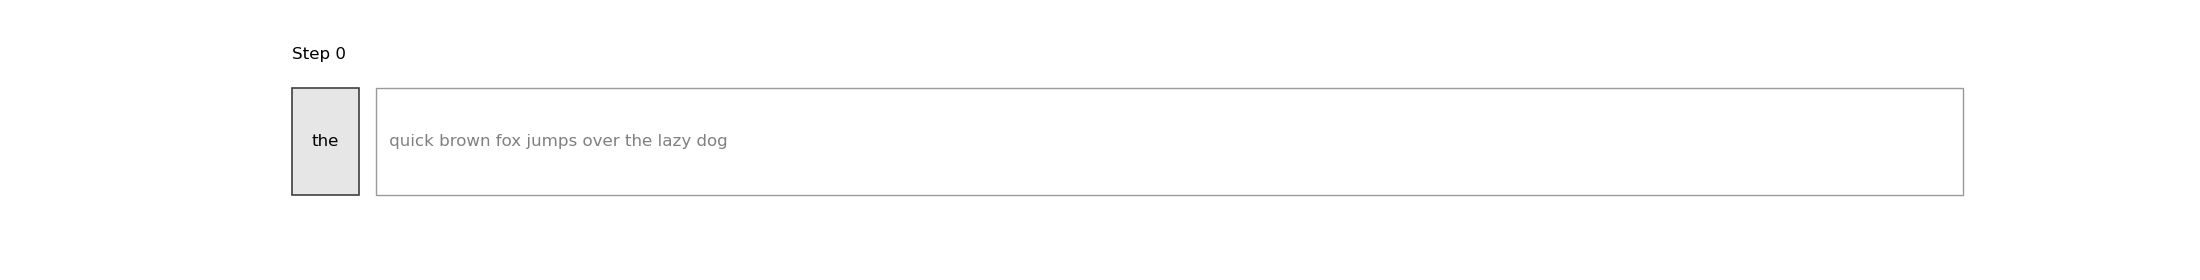
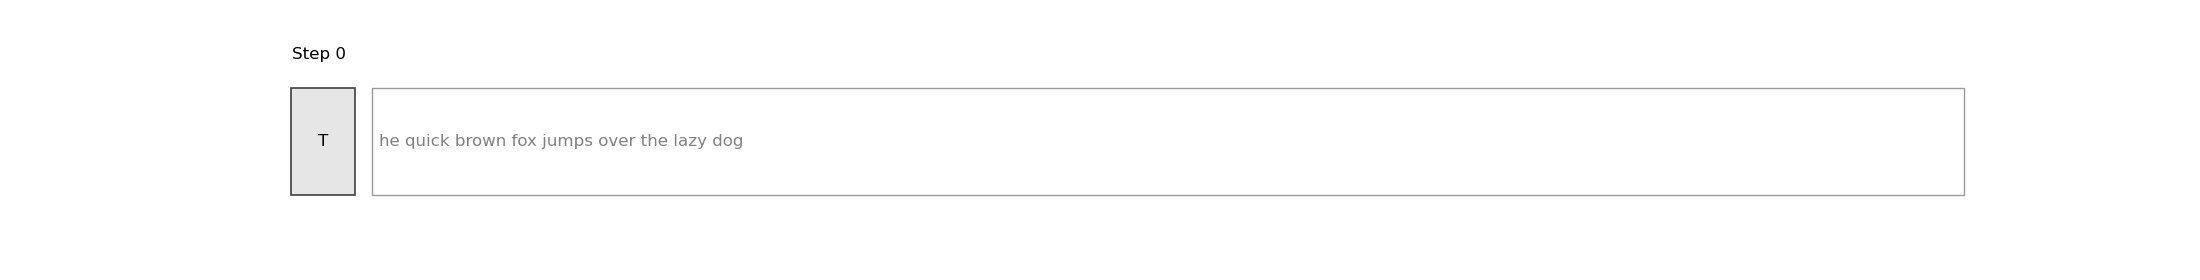